# MNIST Datasets Prediction using Conv2d Models

## 1) Download Datasets

In [231]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root="digitData", train=True, download=True, transform=ToTensor(), target_transform=None)
test_data = datasets.MNIST(root="digitData", train=False, download=True, transform=ToTensor(), target_transform=None)

In [232]:
len(train_data), len(test_data)

(60000, 10000)

In [233]:
class_names = train_data.classes
class_to_inx = train_data.class_to_idx

## 2) Visualize the Datasets

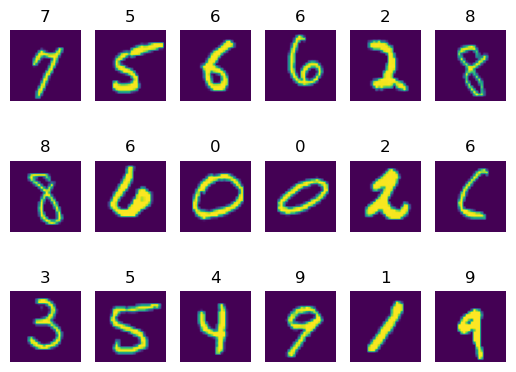

In [234]:
import matplotlib.pyplot as plt
import torch

fig = plt.figure()
rows, cols = 3,6
for i in range(1, rows * cols + 1):
    random_index = torch.randint(0, len(train_data), size=[1]).item()
    image, label = train_data[random_index]
    fig.add_subplot(rows, cols, i)
    plt.imshow(image.squeeze())
    plt.title(label)
    plt.axis(False)

## 3) DataLoaders

In [235]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

dataloader_train = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

dataloader_test = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [236]:
print(len(dataloader_test), len(dataloader_train))
print(len(test_data) / 32, len(train_data) / 32)

313 1875
312.5 1875.0


## 4) Single Batch Visualizer

In [237]:
batch_train_features, batch_train_label = next(iter(dataloader_train))
batch_train_features.shape, batch_train_label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

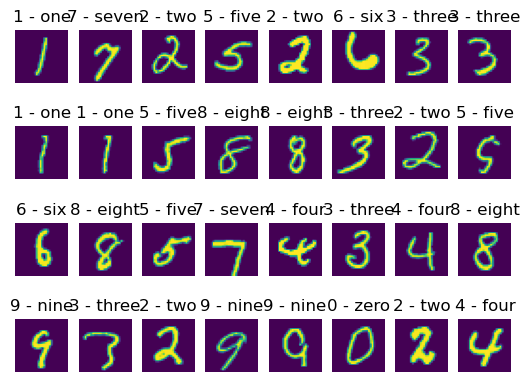

In [238]:
fig = plt.figure()
rows, cols = 4, 8  # Define grid layout
count = 0  # Counter for indexing batch elements

for i in range(1, rows * cols + 1):
    img, label = batch_train_features[count], batch_train_label[count]  # Extract image and label
    fig.add_subplot(rows, cols, i)  # Fix the typo (cols instead of col)
    plt.imshow(img.squeeze())  # Ensure grayscale display
    plt.title(class_names[label])  # Ensure class_names is defined
    plt.axis("off")  # Fix axis off syntax
    count += 1  # Increment count

plt.show()  # Show the plot



## 5) Build a model|

In [239]:
batch_train_features.shape, batch_train_label.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [240]:
from torch import nn
class MNISTModel(nn.Module):
    def __init__(self, input_shape, hidden_unit, output_shape):
        super().__init__()
        self.layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_unit, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, stride=1, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, stride=1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit, stride=1, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2)
        )
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_unit * 7 * 7, out_features=output_shape)
        )

    def forward(self, x):
        # print("First iomage shape", x.shape)
        x = self.layer_1(x)
        # print("After first conv block", x.shape)
        x = self.layer_2(x)
        # print("After second conv block", x.shape)
        x = self.output(x)
        # print("After output block", x.shape)

        return x

In [241]:
dummy_image = torch.randn(size=(1,1,28,28))

In [242]:
model = MNISTModel(1, 6, len(class_names))
model(dummy_image).shape

torch.Size([1, 10])

## 6) Loss Funnction / Optimzier / Accuracy

In [243]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    return (correct/len(y_pred))*100

## 7) Train a Model

In [244]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    train_loss = 0
    train_acc = 0

    for batch, (img, label) in tqdm(enumerate(dataloader_train)):
        model.train()
        y_pred = model(img)
        loss = loss_fn(y_pred, label)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim = 1), label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader_train)
    train_acc /= len(dataloader_train)

    print(f"Train Acc : {train_acc:.4f} Train Loss : {train_loss:.4f}")

    test_loss = 0
    test_acc = 0

    model.eval()

    with torch.inference_mode():
        for test_img, test_label in dataloader_test:
            test_pred = model(test_img)
            test_loss += loss_fn(test_pred, test_label)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), test_label)

        test_loss /= len(dataloader_test)
        test_acc /= len(dataloader_test)

        print(f"Test Acc : {test_acc:.4f} Test Loss : {test_loss:.4f}")
    


  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Train Acc : 61.6683 Train Loss : 1.0913
Test Acc : 93.9796 Test Loss : 0.1928


0it [00:00, ?it/s]

Train Acc : 95.0200 Train Loss : 0.1660
Test Acc : 96.4557 Test Loss : 0.1123


0it [00:00, ?it/s]

Train Acc : 96.4517 Train Loss : 0.1149
Test Acc : 97.3742 Test Loss : 0.0853


## 8) Visualize Predictions

In [245]:
test_features_batch, test_labels_batch = next(iter(dataloader_test))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [246]:
# model(test_features_batch[0]).shape

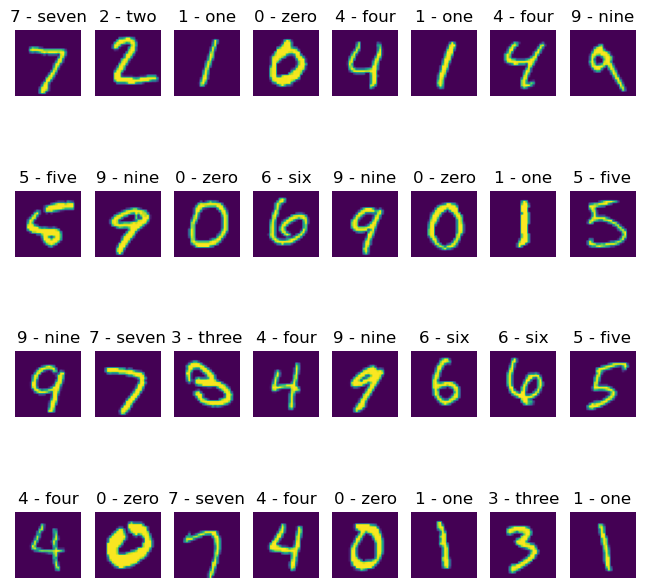

In [247]:
# Ensure train_features_batch and train_labels_batch contain a batch of data
fig = plt.figure(figsize=(8,8))
rows, cols = 4, 8  # Define grid layout
count = 0  # Counter for indexing batch elements

for i in range(1, rows * cols + 1):
    img, label = test_features_batch[count], test_labels_batch[count]  # Extract image and label
    output = model(test_features_batch[count].unsqueeze(0)) 
    predict_class = class_names[output.argmax(dim=1)]
    fig.add_subplot(rows, cols, i)  # Fix the typo (cols instead of col)
    plt.imshow(img.squeeze())  # Ensure grayscale display
    plt.title(predict_class)  # Ensure class_names is defined
    plt.axis("off")  # Fix axis off syntax
    count += 1  # Increment count

plt.show()  # Show the plot


## 9) Summazrize the Model

In [248]:
from torchinfo import summary

summary(model, input_size=(32,1,28, 28)) 

Layer (type:depth-idx)                   Output Shape              Param #
MNISTModel                               [32, 10]                  --
├─Sequential: 1-1                        [32, 6, 14, 14]           --
│    └─Conv2d: 2-1                       [32, 6, 28, 28]           60
│    └─ReLU: 2-2                         [32, 6, 28, 28]           --
│    └─Conv2d: 2-3                       [32, 6, 28, 28]           330
│    └─MaxPool2d: 2-4                    [32, 6, 14, 14]           --
├─Sequential: 1-2                        [32, 6, 7, 7]             --
│    └─Conv2d: 2-5                       [32, 6, 14, 14]           330
│    └─ReLU: 2-6                         [32, 6, 14, 14]           --
│    └─Conv2d: 2-7                       [32, 6, 14, 14]           330
│    └─MaxPool2d: 2-8                    [32, 6, 7, 7]             --
├─Sequential: 1-3                        [32, 10]                  --
│    └─Flatten: 2-9                      [32, 294]                 --
│    └─Linea

 # Confusion Matrix

In [249]:
from tqdm.auto import tqdm

y_pred = []
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_data):
        y_p = model(X.unsqueeze(0))
        y_pred.append(y_p.argmax().item())

print(len(y_pred))

  0%|          | 0/10000 [00:00<?, ?it/s]

10000


In [250]:
y_pred_tensor = torch.tensor(y_pred)
y_pred_tensor.shape, test_data.targets.shape

(torch.Size([10000]), torch.Size([10000]))

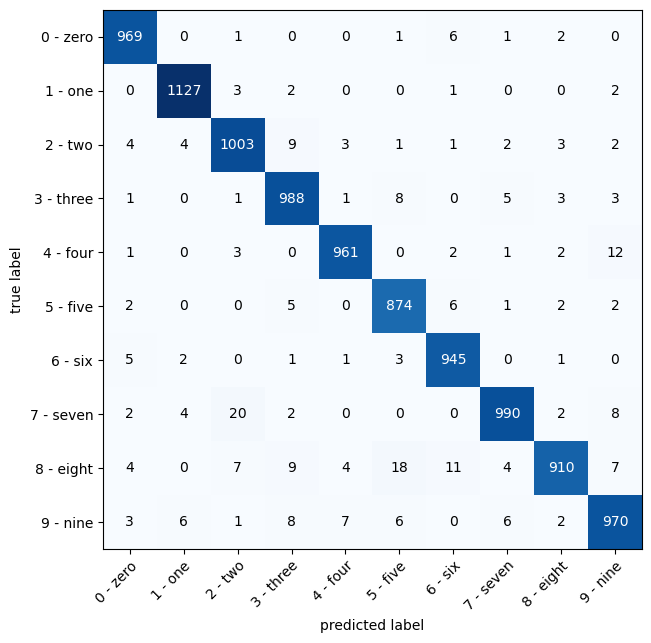

In [251]:
# %pip install torchmetrics -U mlxtend 

import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
    class_names=class_names,
    figsize=(10, 7)
)

## 11. Save and load best performing model

In [252]:
from pathlib import Path

# Create model dictory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models\03_pytorch_computer_vision_model_2.pth


In [ ]:
# # Create a new instance
# torch.manual_seed(42)

# loaded_model_2 = MNISTModel(input_shape=1,
#                                      hidden_units=10,
#                                      output_shape=len(class_names))

# # Load in the save state_dict()
# loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

TypeError: MNISTModel.__init__() got an unexpected keyword argument 'hidden_units'